In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

In [3]:
class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """

    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 7352 training series
        self.test_data_count = len(X_test)  # 2947 testing series
        self.n_steps = len(X_train[0])  # 128 time_steps per series

        # Training
        self.learning_rate = 0.0025
        self.lambda_loss_amount = 0.0015
        self.training_epochs = 300
        self.batch_size = 1500

        # LSTM structure
        self.n_inputs = len(X_train[0][0])  # Features count is of 9: 3 * 3D sensors features over time
        self.n_hidden = 32  # nb of neurons inside the neural network
        self.n_classes = 6  # Final output classes
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))
        }
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))
        }

In [4]:
def LSTM_Network(_X, config):
    """Function returns a TensorFlow RNN with two stacked LSTM cells
    Two LSTM cells are stacked which adds deepness to the neural network.
    Note, some code of this notebook is inspired from an slightly different
    RNN architecture used on another dataset, some of the credits goes to
    "aymericdamien".
    Args:
        _X:     ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        config: Config for the neural network.
    Returns:
        This is a description of what is returned.
    Raises:
        KeyError: Raises an exception.
      Args:
        feature_mat: ndarray fature matrix, shape=[batch_size,time_steps,n_inputs]
        config: class containing config of network
      return:
              : matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']


In [5]:
if __name__ == "__main__":
    # -----------------------------
    # Step 1: load and prepare data
    # -----------------------------

    # Those are separate normalised input features for the neural network
    INPUT_SIGNAL_TYPES = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",
        "total_acc_x_",
        "total_acc_y_",
        "total_acc_z_"
    ]

    # Output classes to learn how to classify
    LABELS = [
        "WALKING",
        "WALKING_UPSTAIRS",
        "WALKING_DOWNSTAIRS",
        "SITTING",
        "STANDING",
        "LAYING"
    ]

    DATA_PATH = ""
    DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
    print("\n" + "Dataset is now located at: " + DATASET_PATH)
    TRAIN = "train/"
    TEST = "test/"

    X_train_signals_paths = [
        DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
    ]
    X_test_signals_paths = [
        DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
    ]
    X_train = load_X(X_train_signals_paths)
    X_test = load_X(X_test_signals_paths)
    #print(X_train[0][120:])
    k=0.0
    for i in range(128-128//10):
        k=k+0.1
        X_train=np.delete(X_train,int(k),axis=1)
    k=0.0
    for i in range(128-128//10):
        k=k+0.1
        X_test=np.delete(X_test,int(k),axis=1)
    #print(k)
    #print('h')
    print(X_train[0].shape)
    
    y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
    y_test_path = DATASET_PATH + TEST + "y_test.txt"
    y_train = one_hot(load_y(y_train_path))
    y_test = one_hot(load_y(y_test_path))
    
    
    
    
    config = Config(X_train, X_test)
    print("Some useful info to get an insight on dataset's shape and normalisation:")
    print("features shape, labels shape, each features mean, each features standard deviation")
    print(X_test.shape, y_test.shape,
          np.mean(X_test), np.std(X_test))
    print("the dataset is therefore properly normalised, as expected.")


Dataset is now located at: UCI HAR Dataset/
(12, 9)
Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
(2947, 12, 9) (2947, 6) 0.0991508 0.395822
the dataset is therefore properly normalised, as expected.


In [6]:
    X = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs])
    Y = tf.placeholder(tf.float32, [None, config.n_classes])

    pred_Y = LSTM_Network(X, config)

    # Loss,optimizer,evaluation
    l2 = config.lambda_loss_amount * \
        sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    # Softmax loss and L2
    cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=pred_Y)) + l2
    optimizer = tf.train.AdamOptimizer(
        learning_rate=config.learning_rate).minimize(cost)

    correct_pred = tf.equal(tf.argmax(pred_Y, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [8]:
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
    init = tf.global_variables_initializer()
    sess.run(init)
    y_pre=y_test[0]
    best_accuracy = 0.0
    # Start training for each batch and loop epochs
    for i in range(config.training_epochs):
        for start, end in zip(range(0, config.train_count, config.batch_size),
                              range(config.batch_size, config.train_count + 1, config.batch_size)):
            sess.run(optimizer, feed_dict={X: X_train[start:end],
                                           Y: y_train[start:end]})

        # Test completely at every epoch: calculate accuracy
        pred_out, accuracy_out, loss_out = sess.run(
            [pred_Y, accuracy, cost],
            feed_dict={
                X: X_test,
                Y: y_test
            }
        )
        print("traing iter: {},".format(i) +
              " test accuracy : {},".format(accuracy_out) +
              " loss : {}".format(loss_out))
        if accuracy_out>best_accuracy:
            y_pre=pred_out
        best_accuracy = max(best_accuracy, accuracy_out)

    print("")
    print("final test accuracy: {}".format(accuracy_out))
    print("best epoch's test accuracy: {}".format(best_accuracy))
    print("")

traing iter: 0, test accuracy : 0.49202579259872437, loss : 1.8164609670639038
traing iter: 1, test accuracy : 0.5052595734596252, loss : 1.6679625511169434
traing iter: 2, test accuracy : 0.5724465847015381, loss : 1.5595533847808838
traing iter: 3, test accuracy : 0.5792331099510193, loss : 1.5093190670013428
traing iter: 4, test accuracy : 0.6189345121383667, loss : 1.398862361907959
traing iter: 5, test accuracy : 0.6498133540153503, loss : 1.332991123199463
traing iter: 6, test accuracy : 0.6864607930183411, loss : 1.2628469467163086
traing iter: 7, test accuracy : 0.6925687193870544, loss : 1.2418748140335083
traing iter: 8, test accuracy : 0.7071598172187805, loss : 1.2292225360870361
traing iter: 9, test accuracy : 0.7193756103515625, loss : 1.2261228561401367
traing iter: 10, test accuracy : 0.6996946334838867, loss : 1.2668321132659912
traing iter: 11, test accuracy : 0.7166610360145569, loss : 1.2623350620269775
traing iter: 12, test accuracy : 0.7173396944999695, loss : 1.2

traing iter: 106, test accuracy : 0.8405157923698425, loss : 0.9002662897109985
traing iter: 107, test accuracy : 0.8428910970687866, loss : 0.9040108323097229
traing iter: 108, test accuracy : 0.8408551216125488, loss : 0.9020636081695557
traing iter: 109, test accuracy : 0.8425517678260803, loss : 0.9056077003479004
traing iter: 110, test accuracy : 0.842212438583374, loss : 0.9049798250198364
traing iter: 111, test accuracy : 0.8425517678260803, loss : 0.9057778120040894
traing iter: 112, test accuracy : 0.8432304263114929, loss : 0.9075669646263123
traing iter: 113, test accuracy : 0.8425517678260803, loss : 0.906926155090332
traing iter: 114, test accuracy : 0.8435697555541992, loss : 0.9081970453262329
traing iter: 115, test accuracy : 0.8439090847969055, loss : 0.9095301032066345
traing iter: 116, test accuracy : 0.8425517678260803, loss : 0.9096733331680298
traing iter: 117, test accuracy : 0.8435697555541992, loss : 0.9104903936386108
traing iter: 118, test accuracy : 0.844248

traing iter: 209, test accuracy : 0.8445877432823181, loss : 0.8821864128112793
traing iter: 210, test accuracy : 0.8378011584281921, loss : 0.8869985342025757
traing iter: 211, test accuracy : 0.8337292075157166, loss : 0.8955273628234863
traing iter: 212, test accuracy : 0.8350865244865417, loss : 0.9034322500228882
traing iter: 213, test accuracy : 0.8313539028167725, loss : 0.9163557887077332
traing iter: 214, test accuracy : 0.8249067068099976, loss : 0.9650537371635437
traing iter: 215, test accuracy : 0.826603353023529, loss : 0.9385390281677246
traing iter: 216, test accuracy : 0.8147268295288086, loss : 1.0467275381088257
traing iter: 217, test accuracy : 0.8279606103897095, loss : 0.9661310911178589
traing iter: 218, test accuracy : 0.8184594511985779, loss : 0.9789538979530334
traing iter: 219, test accuracy : 0.8347471952438354, loss : 0.8275090456008911
traing iter: 220, test accuracy : 0.8367831707000732, loss : 0.7841627597808838
traing iter: 221, test accuracy : 0.83881

In [16]:
b = np.zeros_like(y_pre)
b[np.arange(len(y_pre)), y_pre.argmax(1)] = 1
y_pre=b
print(y_pre)
from sklearn.metrics import confusion_matrix
for i in range(y_test.shape[1]):
    print("Col {}".format(i))
    print(confusion_matrix(y_test[:,i], y_pre[:,i]))
    print("")

[[ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 ..., 
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]
Col 0
[[2382   69]
 [  64  432]]

Col 1
[[2385   91]
 [  83  388]]

Col 2
[[2434   93]
 [  48  372]]

Col 3
[[2394   62]
 [  75  416]]

Col 4
[[2351   64]
 [  69  463]]

Col 5
[[2410    0]
 [  40  497]]



In [28]:
n_classes=6

Testing Accuracy: Tensor("mul_7:0", shape=(), dtype=float32)%

Precision: 87.44197667611375%
Recall: 87.13946386155412%
f1_score: 87.22918966256603%

Confusion Matrix:
[[432  18  46   0   0   0]
 [ 36 388  47   0   0   0]
 [ 30  18 372   0   0   0]
 [  0  11   0 416  64   0]
 [  3   4   0  62 463   0]
 [  0  40   0   0   0 497]]

Confusion matrix (normalised to % of total test data):
[[ 14.6589756    0.61079061   1.56090939   0.           0.           0.        ]
 [  1.22158122  13.1659317    1.5948422    0.           0.           0.        ]
 [  1.01798439   0.61079061  12.62300587   0.           0.           0.        ]
 [  0.           0.37326095   0.          14.11605072   2.1717       0.        ]
 [  0.10179844   0.13573125   0.           2.10383439  15.71089172   0.        ]
 [  0.           1.35731244   0.           0.           0.          16.86460876]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data 

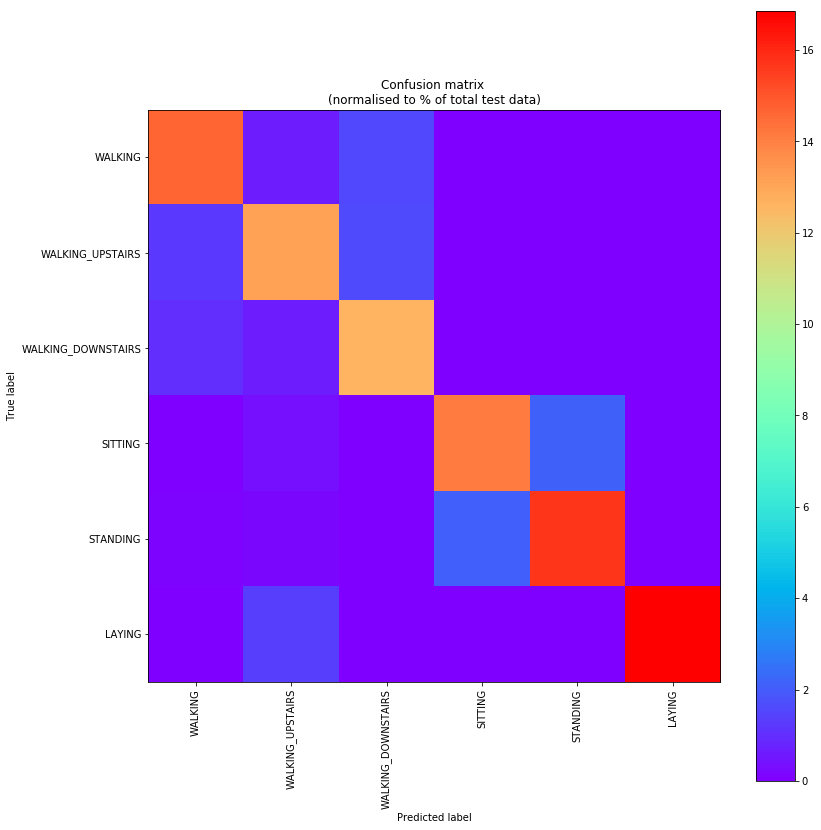

In [30]:
import matplotlib.pyplot as plt
from sklearn import metrics
predictions = y_pre

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
%matplotlib inline
# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()